In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

# Input and output file paths
input_file = "malicious_phish.csv"  # Replace with your input file
output_file = "processed_urls.csv"  # Replace with your desired output file

# Step 1: Load the dataset
df = pd.read_csv(input_file, header=None, names=["url", "type"])

# Step 2: Extract features from URLs
# Example: Length of URL, number of special characters, domain suffix
df['url_length'] = df['url'].apply(len)
df['num_special_chars'] = df['url'].apply(lambda x: sum(1 for char in x if char in ['?', '&', '/', '=', '.', '-']))
df['num_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))

# Vectorize the URLs (character n-grams)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 4), max_features=500)
url_features = vectorizer.fit_transform(df['url']).toarray()
url_feature_names = vectorizer.get_feature_names_out()

# Add the vectorized features to the DataFrame
url_features_df = pd.DataFrame(url_features, columns=[f"url_feature_{name}" for name in url_feature_names])
df = pd.concat([df, url_features_df], axis=1)

# Step 3: One-hot encode the URL type
encoder = OneHotEncoder(sparse_output=False)  # Updated argument name
encoded_labels = encoder.fit_transform(df[['type']])
label_names = encoder.get_feature_names_out(['type'])

# Add encoded labels to the DataFrame
encoded_labels_df = pd.DataFrame(encoded_labels, columns=label_names)
df = pd.concat([df, encoded_labels_df], axis=1)

# Drop the original "url" and "type" columns as they are no longer needed
df.drop(columns=["url", "type"], inplace=True)

# Step 4: Save the processed data to a new CSV file
df.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Load the data
def load_and_preprocess_data(data):
    # Separate features and target
    # The last 6 columns are the target variables (type_*)
    X = data.iloc[:, :-6]
    y = data.iloc[:, -6:]

    # Since we have multiple target columns but they're one-hot encoded,
    # we need to convert them back to a single target variable
    y = y.idxmax(axis=1)
    y = y.str.replace('type_', '')

    return X, y

def create_svm_pipeline():
    # Create a pipeline with standardization and SVM
    # The standardization step performs L2 normalization
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, random_state=42))
    ])
    return pipeline
# /content/processed_urls.csv
def main():
    # Read the data
    data = pd.read_csv('/content/processed_urls.csv')

    # Preprocess the data
    X, y = load_and_preprocess_data(data)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create and train the pipeline
    pipeline = create_svm_pipeline()
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Print results
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Print accuracy
    accuracy = pipeline.score(X_test, y_test)
    print(f"\nAccuracy: {accuracy:.4f}")

    # Print feature importance (using SVM coefficients if linear kernel)
    if pipeline.named_steps['svm'].kernel == 'linear':
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': np.abs(pipeline.named_steps['svm'].coef_[0])
        })
        print("\nTop 10 Most Important Features:")
        print(feature_importance.sort_values('importance', ascending=False).head(10))

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def load_and_preprocess_data(data):
    print("Loading and preprocessing data...")

    # Convert string data to numeric
    data = data.apply(pd.to_numeric, errors='coerce')

    # Separate features and target
    target_columns = ['type_benig', 'type_benign', 'type_defacement',
                     'type_malware', 'type_phishing', 'type_type']

    X = data.drop(target_columns, axis=1)
    y = data[target_columns]

    # Convert to single target by taking the index of maximum value
    y = y.idxmax(axis=1)
    # Clean up target names
    y = y.str.replace('type_', '')

    print(f"Features shape: {X.shape}")
    print(f"Unique classes: {y.unique()}")
    print(f"Number of NaN values in features: {X.isna().sum().sum()}")

    return X, y

def create_svm_pipeline():
    print("Creating SVM pipeline...")
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Add imputer to handle NaN values
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=1.0, random_state=42))
    ])
    return pipeline

def main():
    # Read the data
    print("Reading data...")
    try:
        data = pd.read_csv('/content/processed_urls.csv', sep=',')
        print(f"Data loaded successfully. Shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    try:
        # Preprocess the data
        X, y = load_and_preprocess_data(data)

        # Split the data
        print("Splitting data into train and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Create and train the pipeline
        print("Training SVM classifier...")
        pipeline = create_svm_pipeline()
        pipeline.fit(X_train, y_train)

        # Make predictions
        print("Making predictions...")
        y_pred = pipeline.predict(X_test)

        # Print results
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        # Print accuracy
        accuracy = pipeline.score(X_test, y_test)
        print(f"\nAccuracy: {accuracy:.4f}")

        # Print feature importance for linear kernel
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': np.abs(pipeline.named_steps['svm'].coef_[0])
        })
        print("\nTop 10 Most Important Features:")
        print(feature_importance.sort_values('importance', ascending=False).head(10))

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    main()

Reading data...
Data loaded successfully. Shape: (226927, 509)
Loading and preprocessing data...
Features shape: (226927, 503)
Unique classes: ['type' 'phishing' 'benign' 'defacement' 'malware' 'benig']
Number of NaN values in features: 0
Splitting data into train and test sets...
Training SVM classifier...
Creating SVM pipeline...


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer  # Changed from StandardScaler to Normalizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

def load_and_preprocess_data(data):
    print("Loading and preprocessing data...")

    # Convert string data to numeric
    data = data.apply(pd.to_numeric, errors='coerce')

    # Separate features and target
    target_columns = ['type_benig', 'type_benign', 'type_defacement',
                     'type_malware', 'type_phishing', 'type_type']

    X = data.drop(target_columns, axis=1)
    y = data[target_columns]

    # Convert to single target by taking the index of maximum value
    y = y.idxmax(axis=1)
    # Clean up target names
    y = y.str.replace('type_', '')

    print(f"Features shape: {X.shape}")
    print(f"Unique classes: {y.unique()}")
    print(f"Number of NaN values in features: {X.isna().sum().sum()}")

    return X, y

def main():
    # Read the data
    print("Reading data...")
    try:
        data = pd.read_csv('/content/processed_urls.csv', sep=',')
        print(f"Data loaded successfully. Shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    try:
        # Preprocess the data
        X, y = load_and_preprocess_data(data)

        # Split the data
        print("Splitting data into train and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Handle missing values
        print("Handling missing values...")
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        # Perform L2 normalization
        print("Performing L2 normalization...")
        normalizer = Normalizer(norm='l2')  # Changed to Normalizer
        X_train_normalized = normalizer.fit_transform(X_train_imputed)  # Changed variable name
        X_test_normalized = normalizer.transform(X_test_imputed)  # Changed variable name

        # Create and train the SVM
        print("Training SVM classifier...")
        svm = SVC(kernel='linear', C=1.0, random_state=42)
        svm.fit(X_train_normalized, y_train)  # Updated variable name

        # Make predictions
        print("Making predictions...")
        y_pred = svm.predict(X_test_normalized)  # Updated variable name

        # Print results
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        # Print accuracy
        accuracy = svm.score(X_test_normalized, y_test)  # Updated variable name
        print(f"\nAccuracy: {accuracy:.4f}")

        # Print feature importance for linear kernel
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': np.abs(svm.coef_[0])
        })
        print("\nTop 10 Most Important Features:")
        print(feature_importance.sort_values('importance', ascending=False).head(10))

        # Save the model and preprocessing objects if needed
        import joblib
        joblib.dump(imputer, 'imputer.joblib')
        joblib.dump(normalizer, 'normalizer.joblib')  # Updated variable name
        joblib.dump(svm, 'svm_model.joblib')
        print("\nModel and preprocessing objects saved to disk.")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    main()

Reading data...
Data loaded successfully. Shape: (226927, 509)
Loading and preprocessing data...
Features shape: (226927, 503)
Unique classes: ['type' 'phishing' 'benign' 'defacement' 'malware' 'benig']
Number of NaN values in features: 0
Splitting data into train and test sets...
Handling missing values...
Performing L2 normalization...
Training SVM classifier...
Making predictions...

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       benig       0.00      0.00      0.00         1
      benign       0.97      0.99      0.98     33075
  defacement       0.92      0.97      0.94      8589
     malware       0.95      0.47      0.63      1032
    phishing       0.92      0.63      0.75      2689

    accuracy                           0.96     45386
   macro avg       0.75      0.61      0.66     45386
weighted avg       0.96      0.96      0.95     45386


Confusion Matrix:
[[    0     1     0     0     0]
 [    0 32883   105    17    70]
 [    0   273  8309     2     5]
 [    0   279   196   490    67]
 [    0   561   416     5  1707]]

Accuracy: 0.9560

Top 10 Most Important Features:
              feature  importance
490    url_feature_ww   17.194538
56   url_feature_//ww   11.308492
464  url_feature_ttp:   11.010873
457   url_feature_tp:   11.010873
458  url_feature_tp:/   11.005964
373   url_feature_p:/   11.005964
374  url_feature_p://   10.987886
372

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def load_and_preprocess_data(data):
    print("Loading and preprocessing data...")

    # Convert string data to numeric
    data = data.apply(pd.to_numeric, errors='coerce')

    # Separate features and target
    target_columns = ['type_benig', 'type_benign', 'type_defacement',
                     'type_malware', 'type_phishing', 'type_type']

    X = data.drop(target_columns, axis=1)
    y = data[target_columns]

    # Handle NaN values in target columns before idxmax
    # Fill NaN with 0 in target columns since they represent absence of that class
    y = y.fillna(0)

    # Convert to single target by taking the index of maximum value
    # Add a condition to handle rows where all values are 0
    max_values = y.max(axis=1)
    y = y.idxmax(axis=1)

    # For rows where all values were 0, assign an 'unknown' class
    y = pd.Series(np.where(max_values == 0, 'unknown', y), index=y.index)

    # Clean up target names
    y = y.str.replace('type_', '')

    # Remove classes with too few samples (less than minimum_samples)
    minimum_samples = 2
    class_counts = y.value_counts()
    valid_classes = class_counts[class_counts >= minimum_samples].index
    mask = y.isin(valid_classes)
    X = X[mask]
    y = y[mask]

    print(f"Features shape: {X.shape}")
    print(f"Unique classes: {y.unique()}")
    print(f"Number of NaN values in features: {X.isna().sum().sum()}")
    print(f"Class distribution:\n{y.value_counts()}")

    return X, y

def main():
    # Read the data
    print("Reading data...")
    try:
        data = pd.read_csv('/content/processed_urls.csv', sep=',')
        print(f"Data loaded successfully. Shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    try:
        # Preprocess the data
        X, y = load_and_preprocess_data(data)

        # Remove any rows where y is 'unknown' if you don't want to classify them
        mask = y != 'unknown'
        X = X[mask]
        y = y[mask]

        # Check if we have enough samples per class for stratification
        min_samples_per_class = y.value_counts().min()

        # Split the data
        print("Splitting data into train and test sets...")
        if min_samples_per_class >= 2:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            print("Using stratified split")
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
            print("Using random split (insufficient samples for stratification)")

        # Create pipeline with imputer, L2 normalization, and Naive Bayes
        print("Creating pipeline with imputer, L2 normalization, and Naive Bayes...")
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('normalizer', Normalizer(norm='l2')),
            ('nb', MultinomialNB(alpha=1.0))
        ])

        # Train the pipeline
        print("Training Naive Bayes classifier with L2 normalization...")
        pipeline.fit(X_train, y_train)

        # Make predictions
        print("Making predictions...")
        y_pred = pipeline.predict(X_test)

        # Get probability estimates
        y_prob = pipeline.predict_proba(X_test)

        # Print results
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        # Print accuracy
        accuracy = pipeline.score(X_test, y_test)
        print(f"\nAccuracy: {accuracy:.4f}")

        # Get feature importance for Naive Bayes
        nb_classifier = pipeline.named_steps['nb']

        # Calculate feature importance using log probabilities
        feature_importance_scores = []
        for i, class_label in enumerate(nb_classifier.classes_):
            log_probs = nb_classifier.feature_log_prob_[i]
            feature_importance_scores.append(log_probs)

        # Average importance across classes
        mean_importance = np.mean(np.abs(feature_importance_scores), axis=0)

        # Create feature importance DataFrame
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': mean_importance
        })

        print("\nTop 10 Most Important Features:")
        print(feature_importance.sort_values('importance', ascending=False).head(10))

        # Print probability distribution for a few examples
        print("\nProbability Distribution for First 5 Test Samples:")
        for i in range(min(5, len(y_test))):
            print(f"\nSample {i+1}:")
            print(f"True label: {y_test.iloc[i]}")
            print(f"Predicted label: {y_pred[i]}")
            print("Class probabilities:")
            for class_label, prob in zip(pipeline.classes_, y_prob[i]):
                print(f"  {class_label}: {prob:.4f}")

        # Save the model and preprocessing pipeline
        import joblib
        joblib.dump(pipeline, 'naive_bayes_pipeline.joblib')
        print("\nModel pipeline saved to disk.")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    main()

Reading data...
Data loaded successfully. Shape: (226927, 509)
Loading and preprocessing data...
Features shape: (226925, 503)
Unique classes: ['phishing' 'benign' 'defacement' 'malware']
Number of NaN values in features: 0
Class distribution:
benign        165965
defacement     41934
phishing       13595
malware         5431
Name: count, dtype: int64
Splitting data into train and test sets...
Using stratified split
Creating pipeline with imputer, L2 normalization, and Naive Bayes...
Training Naive Bayes classifier with L2 normalization...
Making predictions...

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      benign       0.82      1.00      0.90     33193
  defacement       0.96      0.59      0.73      8387
     malware       0.00      0.00      0.00      1086
    phishing       0.00      0.00      0.00      2719

    accuracy                           0.84     45385
   macro avg       0.45      0.40      0.41     45385
weighted avg       0.78      0.84      0.80     45385


Confusion Matrix:
[[33158    35     0     0]
 [ 3434  4953     0     0]
 [ 1030    56     0     0]
 [ 2610   109     0     0]]

Accuracy: 0.8397

Top 10 Most Important Features:
              feature  importance
8      url_feature_%d    9.343065
17   url_feature_&vie    9.276023
16    url_feature_&vi    9.256591
347  url_feature_om_c    9.240471
295  url_feature_m_co    9.210298
191  url_feature_ent&    9.194015
94     url_feature_9%    9.178608
329   url_feature_nt&    9.172842
487  url_feature_wiki    9.168066
14   url_feature_&ite    9.151934

Probability

Reading data...
Data loaded successfully. Shape: (226927, 509)
Loading and preprocessing data...

Class distribution before filtering:
benign        165965
defacement     41934
phishing       13595
malware         5431
type               1
benig              1
Name: count, dtype: int64

Class distribution after filtering:
benign        165965
defacement     41934
phishing       13595
malware         5431
Name: count, dtype: int64

Features shape: (226925, 503)
Unique classes: ['phishing' 'benign' 'defacement' 'malware']
Number of NaN values in features: 0

Splitting data into train and test sets...
Creating pipeline with imputer, L2 normalization, and Random Forest...
Training Random Forest classifier with L2 normalization...
Making predictions...

Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     33193
  defacement       0.97      0.99      0.98      8387
     malware       0.99      0.86      0.92      1086
 

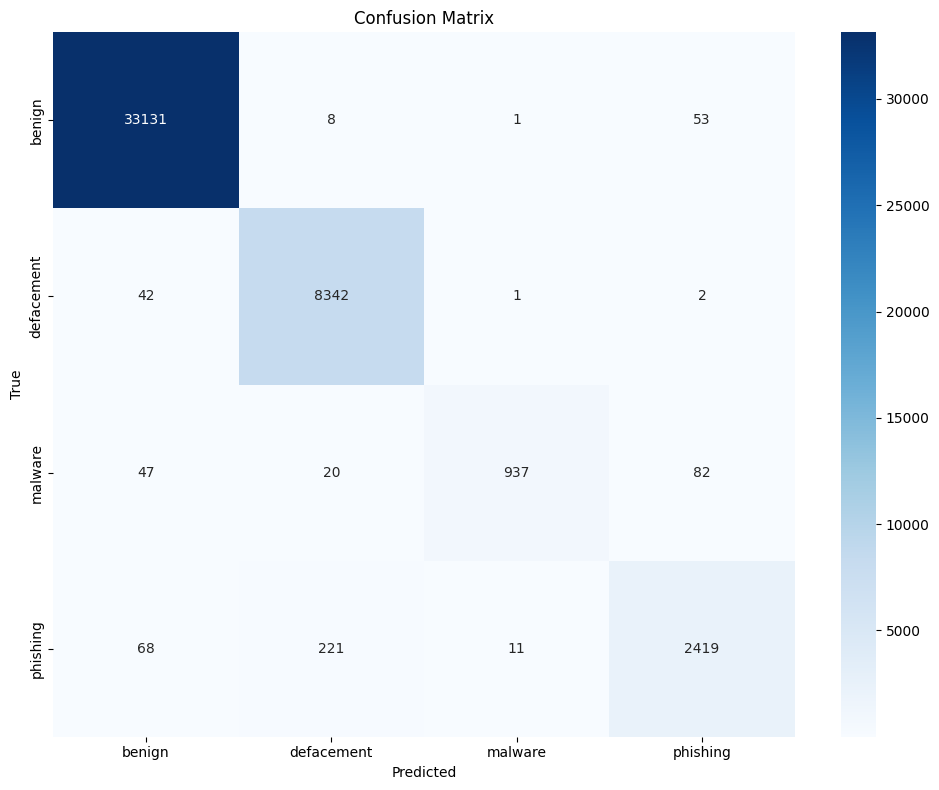


Accuracy: 0.9877

Top 10 Most Important Features:
               feature  importance
289     url_feature_m/    0.044635
343    url_feature_om/    0.035619
151   url_feature_com/    0.030561
234    url_feature_htt    0.023240
54      url_feature_//    0.021941
464   url_feature_ttp:    0.020207
458   url_feature_tp:/    0.019854
95      url_feature_:/    0.019613
1    num_special_chars    0.018803
373    url_feature_p:/    0.018725


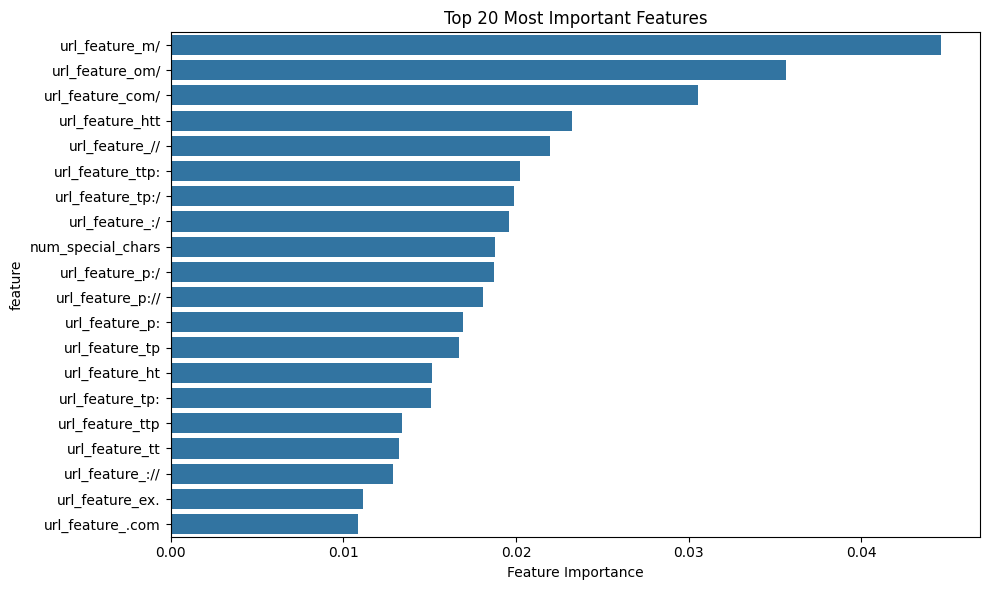


Detailed Analysis of Misclassifications:
Number of misclassified samples: 556

Probability Distribution for First 5 Misclassified Samples:

Sample 78394:
True label: benign
Predicted label: phishing
Class probabilities:
  benign: 0.4900
  defacement: 0.0000
  malware: 0.0100
  phishing: 0.5000

Sample 16708:
True label: benign
Predicted label: phishing
Class probabilities:
  benign: 0.1100
  defacement: 0.0000
  malware: 0.0300
  phishing: 0.8600

Sample 189984:
True label: malware
Predicted label: benign
Class probabilities:
  benign: 0.9900
  defacement: 0.0000
  malware: 0.0100
  phishing: 0.0000

Sample 150239:
True label: phishing
Predicted label: defacement
Class probabilities:
  benign: 0.0000
  defacement: 0.5300
  malware: 0.0100
  phishing: 0.4600

Sample 65705:
True label: malware
Predicted label: defacement
Class probabilities:
  benign: 0.0500
  defacement: 0.6300
  malware: 0.0700
  phishing: 0.2500

Model pipeline saved to disk.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(data):
    print("Loading and preprocessing data...")

    # Convert string data to numeric
    data = data.apply(pd.to_numeric, errors='coerce')

    # Separate features and target
    target_columns = ['type_benig', 'type_benign', 'type_defacement',
                     'type_malware', 'type_phishing', 'type_type']

    X = data.drop(target_columns, axis=1)
    y = data[target_columns]

    # Convert to single target by taking the index of maximum value
    y = y.idxmax(axis=1)
    # Clean up target names
    y = y.str.replace('type_', '')

    # Print class distribution
    print("\nClass distribution before filtering:")
    print(y.value_counts())

    # Remove classes with too few samples (less than 2)
    class_counts = y.value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    mask = y.isin(valid_classes)

    X = X[mask]
    y = y[mask]

    print("\nClass distribution after filtering:")
    print(y.value_counts())

    print(f"\nFeatures shape: {X.shape}")
    print(f"Unique classes: {y.unique()}")
    print(f"Number of NaN values in features: {X.isna().sum().sum()}")

    return X, y

def plot_feature_importance(feature_importance_df, top_n=20):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature',
                data=feature_importance_df.head(top_n))
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def main():
    print("Reading data...")
    try:
        data = pd.read_csv('/content/processed_urls.csv', sep=',')
        print(f"Data loaded successfully. Shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    try:
        # Preprocess the data
        X, y = load_and_preprocess_data(data)

        # Split the data with stratification for classes that have enough samples
        print("\nSplitting data into train and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Create pipeline with imputer, L2 normalization, and Random Forest
        print("Creating pipeline with imputer, L2 normalization, and Random Forest...")
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('normalizer', Normalizer(norm='l2')),
            ('rf', RandomForestClassifier(
                n_estimators=100,
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                max_features='sqrt',
                bootstrap=True,
                random_state=42,
                n_jobs=-1,
                class_weight='balanced'
            ))
        ])

        # Train the pipeline
        print("Training Random Forest classifier with L2 normalization...")
        pipeline.fit(X_train, y_train)

        # Make predictions
        print("Making predictions...")
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)

        # Print results
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        # Plot confusion matrix
        plot_confusion_matrix(cm, classes=pipeline.classes_)

        # Print accuracy
        accuracy = pipeline.score(X_test, y_test)
        print(f"\nAccuracy: {accuracy:.4f}")

        # Get feature importance
        rf_classifier = pipeline.named_steps['rf']
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': rf_classifier.feature_importances_
        })

        # Sort feature importance
        feature_importance = feature_importance.sort_values(
            'importance', ascending=False
        )

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))

        # Plot feature importance
        plot_feature_importance(feature_importance)

        # Print detailed analysis of misclassifications
        print("\nDetailed Analysis of Misclassifications:")
        misclassified_indices = y_test.index[y_test != y_pred]
        print(f"Number of misclassified samples: {len(misclassified_indices)}")

        # Print probability distribution for misclassified examples
        print("\nProbability Distribution for First 5 Misclassified Samples:")
        for idx in misclassified_indices[:5]:
            test_index = y_test.index.get_loc(idx)
            print(f"\nSample {idx}:")
            print(f"True label: {y_test.iloc[test_index]}")
            print(f"Predicted label: {y_pred[test_index]}")
            print("Class probabilities:")
            for class_label, prob in zip(pipeline.classes_, y_prob[test_index]):
                print(f"  {class_label}: {prob:.4f}")

        # Save the model and preprocessing pipeline
        import joblib
        joblib.dump(pipeline, 'random_forest_pipeline.joblib')
        print("\nModel pipeline saved to disk.")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    main()